In [1]:
import s2sphere
from itertools import combinations
from itertools import chain
import shapefile
import numpy as np
from shapely.geometry import Polygon, Point, shape
from rasterstats import zonal_stats, point_query
import pandas as pd
import s2sphere
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

/Users/qianzh/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def find_1_neighbour(cell_id_str):
    new_cellid =s2sphere.CellId.from_token(cell_id_str)
    sxzy = new_cellid.get_edge_neighbors()
    comb = combinations(sxzy,2)
    corner = []
    for i in comb:
        common = list(set(i[0].get_edge_neighbors()).intersection(i[1].get_edge_neighbors()))
        corner.append(common)
    corner = list(chain(*corner))
    corner = list(filter(lambda a: a != new_cellid, corner))
    first_neighbor = list(sxzy) + corner
    return(first_neighbor)

In [3]:
def find_2_neighbour(first_neighbor, cell_id_str):
    new_cellid =s2sphere.CellId.from_token(cell_id_str)
    first_sxzy = []
    for cellid in first_neighbor:
        first_sxzy = first_sxzy + list(cellid.get_edge_neighbors())
    first_sxzy = list(set(first_sxzy) - set(first_neighbor))
    first_sxzy = list(filter(lambda a: a != new_cellid, first_sxzy))
    comb_2 = combinations(first_sxzy,2)
    corner_2 = []
    for i in comb_2:
        common = list(set(i[0].get_edge_neighbors()).intersection(i[1].get_edge_neighbors()))
        corner_2.append(common)
    corner_2 = list(chain(*corner_2))
    corner_2 = list(set(corner_2)- set(first_neighbor)- set(first_sxzy))
    second_neighbor = first_sxzy + corner_2
    return(second_neighbor)

In [4]:
def s2_cov(cell_list, rasterfile):
    values  =  []
    for ids in cell_list[:]:
        new_cell = s2sphere.Cell(s2sphere.CellId.from_token(str(ids)))
        vertices = []
        for i in range(0, 4):
            vertex = new_cell.get_vertex(i)
            latlng = s2sphere.LatLng.from_point(vertex)
            vertices.append((latlng.lng().degrees,latlng.lat().degrees))
        geo = Polygon(vertices)
        point_est = point_query(geo.centroid, rasterfile)
        values = values + point_est
    return values

In [5]:
def pop_w_neighbor(id_list, pop_raster):
    pop = 0
    new_id = []
    for cellid in id_list:
        sid = str(cellid)[8:15]
        new_id.append(sid)
    pop = s2_cov(new_id, pop_raster)
    return(pop)

In [6]:
def neighbour_pop_prob(idlist, pop_raster, travel_cell_file):
    country_cell = pd.read_csv(travel_cell_file)
    home_pop = s2_cov(idlist, pop_raster)
    first_pop_sum = []
    second_pop_sum = []
    home_travel = []
    first_travel = []
    second_travel = []
    for cell in idlist:
        first_neighbour = find_1_neighbour(cell)
        second_neighbour = find_2_neighbour(first_neighbour, cell)
        first_ngb_pop = pop_w_neighbor(first_neighbour, pop_raster)
        second_ngb_pop = pop_w_neighbor(second_neighbour, pop_raster)
        first_ngb_pop = pd.Series(first_ngb_pop, dtype=object).fillna(0).tolist()
        second_ngb_pop = pd.Series(second_ngb_pop, dtype=object).fillna(0).tolist()
        first_pop_sum.append(sum(first_ngb_pop))
        second_pop_sum.append(sum(second_ngb_pop))
        first_new_id = []
        for cellid in first_neighbour:
            sid = str(cellid)[8:15]
            first_new_id.append(sid)
        second_new_id = []
        for cellid in second_neighbour:
            sid = str(cellid)[8:15]
            second_new_id.append(sid)
        total_cell = country_cell.loc[country_cell['origin_s2'] == cell]
        if total_cell.shape[0] == 0:
            home_travel.append(0)
            first_travel.append(0)
            second_travel.append(0)
        else:
            home_cell = total_cell.loc[total_cell['dest_s2'] == cell]
            first_cell = total_cell[total_cell['dest_s2'].isin(first_new_id)]
            second_cell = total_cell[total_cell['dest_s2'].isin(second_new_id)]
            home_travel.append(home_cell.shape[0]/total_cell.shape[0])
            first_travel.append(first_cell.shape[0]/total_cell.shape[0])
            second_travel.append(second_cell.shape[0]/total_cell.shape[0])
            print(first_cell.shape[0], second_cell.shape[0], total_cell.shape[0])
        
    results = pd.DataFrame({'home_pop':home_pop,'first_pop_sum':first_pop_sum, 'second_pop_sum':second_pop_sum, 'home_travel':home_travel,
                           'first_travel':first_travel, 'second_travel':second_travel})
    return(results)

In [7]:
def scatter_plot_with_correlation_line(x, y, graph_filepath):
    '''
    http://stackoverflow.com/a/34571821/395857
    x does not have to be ordered.
    '''
    # Scatter plot
    plt.scatter(x, y)

    # Add correlation line
    axes = plt.gca()
    m, b = np.polyfit(x, y, 1)
    X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
    plt.plot(X_plot, m*X_plot + b, '-')

    # Save figure
    plt.savefig(graph_filepath, dpi=300, format='png', bbox_inches='tight')

In [8]:
pop_raster = "/Users/qianzh/project/human_mobility/data/covariates/population/worldpop_total_1y_2016_00_00.tif"

In [9]:
swaziland = pd.read_csv("/Users/qianzh/project/TaR/trial/swaziland/movement_home_in_Swaziland.csv")
cell_file = "/Users/qianzh/project/TaR/trial/swaziland/travel_international_235.csv"
swaziland_pop = neighbour_pop_prob(swaziland['s2_id'], pop_raster, cell_file )
swaziland_pop['s2_id'] = swaziland['s2_id']
swaziland_pop['prop_home'] = swaziland['prop_home']

/Users/qianzh/anaconda3/lib/python3.5/site-packages/rasterstats/point.py:167: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, nodata=nodata, affine=affine, band=band) as rast:
/Users/qianzh/anaconda3/lib/python3.5/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)


0 0 3
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
3 0 7
4 1 16
3 1 8
5 4 22
1 0 2
3 0 6
0 0 1
0 0 1
0 0 1
1 0 2
2 0 3
2 0 3
3 0 4
0 0 1
0 0 1
0 0 1
0 0 1
7 3 21
2 2 5
4 0 9
3 2 39
1 0 7
1 0 6
4 0 11
2 1 4
4 2 7
3 0 5
4 0 12
3 1 9
0 0 1
0 0 1
0 0 1
0 0 1
1 0 2
0 0 1
2 0 3
2 0 3
4 0 6
2 0 3
1 1 3
1 1 3
3 0 5
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
1 0 2
2 0 4
0 0 1
0 0 1
0 0 1
0 0 1
1 0 5
2 0 5
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
1 0 2
0 0 2
0 0 1
0 0 1
0 0 6
0 0 1
0 0 1
0 0 1
1 0 2
3 1 6
0 0 1
1 0 2
2 0 3
0 0 1
1 0 2
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
2 0 3
2 0 3
2 0 3
2 0 3
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 2
3 0 4
1 1 4
1 0 2
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 2
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
1 0 1


In [10]:
swaziland_pop

,first_pop_sum,first_travel,home_pop,home_travel,second_pop_sum,second_travel,s2_id,prop_home
0,659.105224,0.000000,48.021271,0.000000,8466.597052,0.000000,1ee6753,0.000000
1,28493.660269,0.000000,2001.488224,1.000000,65418.624843,0.000000,1ee8caf,1.000000
2,51253.443058,0.000000,4012.634480,1.000000,117939.103298,0.000000,1ee8cbf,1.000000
3,34324.365667,0.000000,2941.365346,1.000000,73472.492202,0.000000,1ee8cad,1.000000
4,44071.305448,0.000000,7203.293397,1.000000,65475.218252,0.000000,1ee8cb1,1.000000
5,47149.779679,0.000000,6769.878980,1.000000,65665.430630,0.000000,1ee8cb3,1.000000
6,49707.098973,0.428571,8251.477092,0.142857,59686.512049,0.000000,1ee8cb5,0.379602
7,53918.958304,0.250000,10369.555648,0.062500,63241.998757,0.062500,1ee8cb7,0.299798
8,50859.592385,0.375000,6877.431030,0.125000,71650.117828,0.125000,1ee8cc9,0.337251
9,37822.542407,0.227273,6086.126550,0.045455,59832.902917,0.181818,1eef34b,0.340694


Text(0.5,1,'Proportion of staying at home with population counts in one cell ')

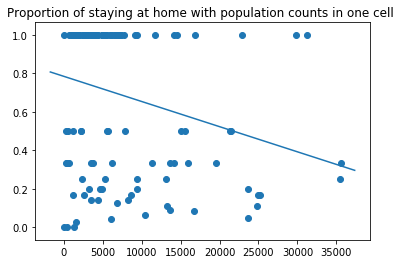

In [12]:
Y = swaziland_pop['home_travel']
X = swaziland_pop['home_pop']
scatter_plot_with_correlation_line(X, Y, "/Users/qianzh/project/TaR/trial/swaziland_home.png")
plt.title("Proportion of staying at home with population counts in one cell ")

In [13]:
est_model = sm.OLS(Y, sm.add_constant(X))
est = est_model.fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:            home_travel   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     9.251
Date:                Tue, 11 Sep 2018   Prob (F-statistic):            0.00287
Time:                        15:27:57   Log-Likelihood:                -52.367
No. Observations:                 127   AIC:                             108.7
Df Residuals:                     125   BIC:                             114.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7844      0.046     17.117      0.0

Text(0.5,1,'Proportion of staying at home with population counts in 3x3 cells ')

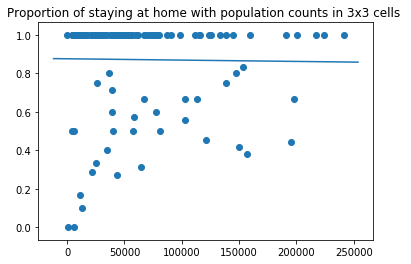

In [15]:
Y1 = swaziland_pop['home_travel'] + swaziland_pop['first_travel']
X1 = swaziland_pop['home_pop'] + swaziland_pop['first_pop_sum']
scatter_plot_with_correlation_line(X1, Y1, "/Users/qianzh/project/TaR/trial/swaziland_first.png")
plt.title("Proportion of staying at home with population counts in 3x3 cells ")

In [16]:
est1_model = sm.OLS(Y1, sm.add_constant(X1))
est1 = est1_model.fit()
print(est1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                   0.02793
Date:                Tue, 11 Sep 2018   Prob (F-statistic):              0.868
Time:                        15:32:19   Log-Likelihood:                -2.7500
No. Observations:                 127   AIC:                             9.500
Df Residuals:                     125   BIC:                             15.19
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8759      0.033     26.340      0.0

Text(0.5,1,'Proportion of staying at home with population counts in 5x5 cells ')

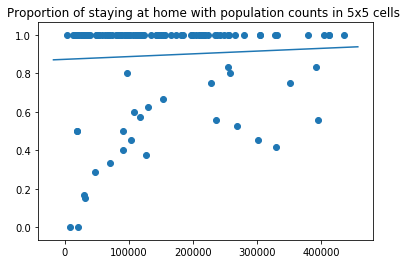

In [17]:
Y2 = swaziland_pop['home_travel']+ swaziland_pop['first_travel'] + swaziland_pop['second_travel']
X2 = swaziland_pop['home_pop'] + swaziland_pop['first_pop_sum'] + swaziland_pop['second_pop_sum']
scatter_plot_with_correlation_line(X2, Y2, "/Users/qianzh/project/TaR/trial/swaziland_second.png")
plt.title("Proportion of staying at home with population counts in 5x5 cells ")

In [18]:
est2_model = sm.OLS(Y2, sm.add_constant(X2))
est2 = est2_model.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.5441
Date:                Tue, 11 Sep 2018   Prob (F-statistic):              0.462
Time:                        15:33:19   Log-Likelihood:                 5.7329
No. Observations:                 127   AIC:                            -7.466
Df Residuals:                     125   BIC:                            -1.777
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8729      0.034     25.552      0.0

Text(0.5,1,'Proportion of staying at home with log(population counts) in one cell ')

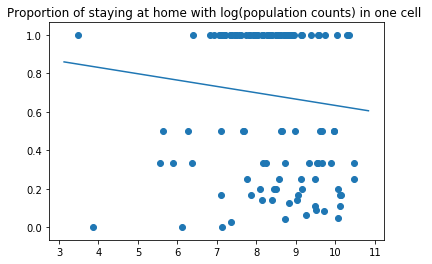

In [21]:
Y_log = swaziland_pop['home_travel']
X_log = np.log(swaziland_pop['home_pop'])
scatter_plot_with_correlation_line(X_log, Y_log, "/Users/qianzh/project/TaR/trial/swaziland_home_log.png")
plt.title("Proportion of staying at home with log(population counts) in one cell ")

Text(0.5,1,'Proportion of staying at home with log(population counts) in 3x3 cells ')

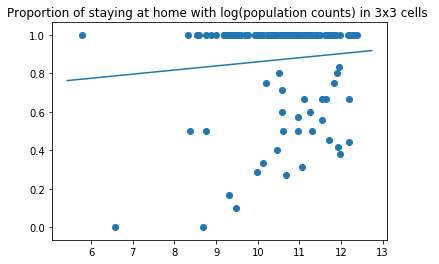

In [22]:
Y1 = swaziland_pop['home_travel'] + swaziland_pop['first_travel']
X1_log = np.log(swaziland_pop['home_pop'] + swaziland_pop['first_pop_sum'])
scatter_plot_with_correlation_line(X1_log, Y1, "/Users/qianzh/project/TaR/trial/swaziland_first_log.png")
plt.title("Proportion of staying at home with log(population counts) in 3x3 cells ")

Text(0.5,1,'Proportion of staying at home with log(population counts) in 5x5 cells ')

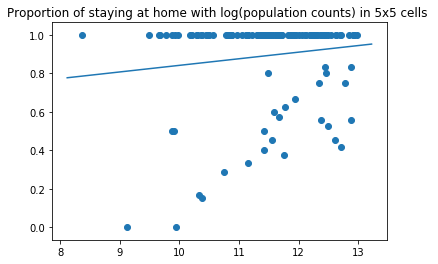

In [25]:
Y2 = swaziland_pop['home_travel']+ swaziland_pop['first_travel'] + swaziland_pop['second_travel']
X2_log = np.log(swaziland_pop['home_pop'] + swaziland_pop['first_pop_sum'] + swaziland_pop['second_pop_sum'])
scatter_plot_with_correlation_line(X2_log, Y2, "/Users/qianzh/project/TaR/trial/swaziland_second_log.png")
plt.title("Proportion of staying at home with log(population counts) in 5x5 cells ")